In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from IPython.display import Image
from tensorflow import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [2]:
with open(r'C:\Users\sushmitha\Downloads\1661-0.txt', 'r', encoding='utf-8') as file:
    text = file.read()

print(text)


﻿
Project Gutenberg's The Adventures of Sherlock Holmes, by Arthur Conan Doyle

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.net


Title: The Adventures of Sherlock Holmes

Author: Arthur Conan Doyle

Release Date: November 29, 2002 [EBook #1661]
Last Updated: May 20, 2019

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES ***



Produced by an anonymous Project Gutenberg volunteer and Jose Menendez



cover



The Adventures of Sherlock Holmes



by Arthur Conan Doyle



Contents


   I.     A Scandal in Bohemia
   II.    The Red-Headed League
   III.   A Case of Identity
   IV.    The Boscombe Valley Mystery
   V.     The Five Orange Pips
   VI.    The Man with the Twisted Lip
   VII.   The Adventure of the Blue 

In [3]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [4]:
path = '1661-0.txt'
with open(path, encoding='latin1') as file:
    text = file.read().lower()

print('corpus length:', len(text))


corpus length: 595481


In [5]:
tokenizer = RegexpTokenizer(r'w+')
words = tokenizer.tokenize(text)

In [6]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [7]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['w', 'w', 'w', 'w', 'w']
www


In [8]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [9]:
print(X[0][0])

[ True False]


In [10]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [11]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=2, shuffle=True).history

C:\Users\sushmitha\anaconda3\envs\tensorflow_env\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/2
86/86 [==============================] - 10s 47ms/step - loss: 0.0099 - accuracy: 0.9882 - val_loss: 0.1884 - val_accuracy: 0.9844
Epoch 2/2
86/86 [==============================] - 1s 17ms/step - loss: 0.0022 - accuracy: 0.9999 - val_loss: 0.2072 - val_accuracy: 0.9844


In [12]:
model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


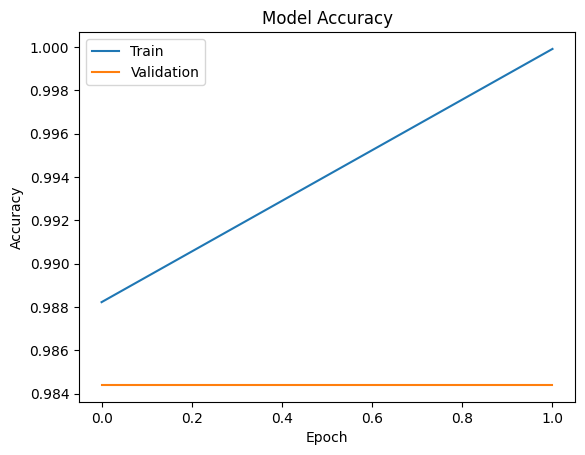

In [13]:
# Assuming 'history' is the dictionary obtained after training your Keras model

# Check the keys available in the 'history' dictionary
print(history.keys())

# Plot the correct training accuracy key (e.g., 'accuracy' or 'acc')
plt.plot(history['accuracy'])  # Use the correct key here
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


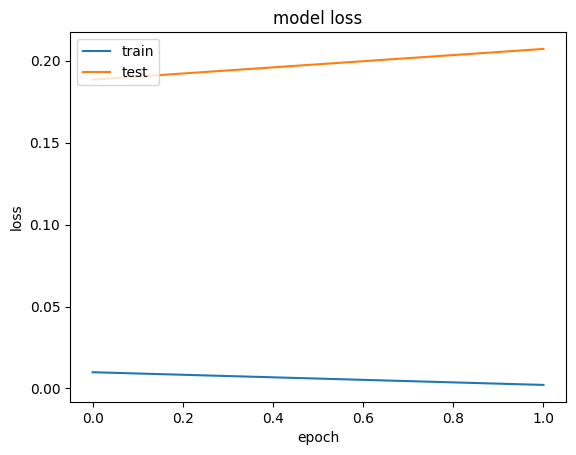

In [14]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [15]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [16]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(unique_words)), dtype=bool)
    words = text.split()
    for t, word in enumerate(words):
        if word in unique_word_index:
            x[0, t, unique_word_index[word]] = 1
    return x


In [17]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [18]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [19]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [20]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [21]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(unique_words)), dtype=bool)
    words = text.split()
    for t, word in enumerate(words):
        if word in unique_words:
            x[0, t, unique_word_index[word]] = 1
    return x


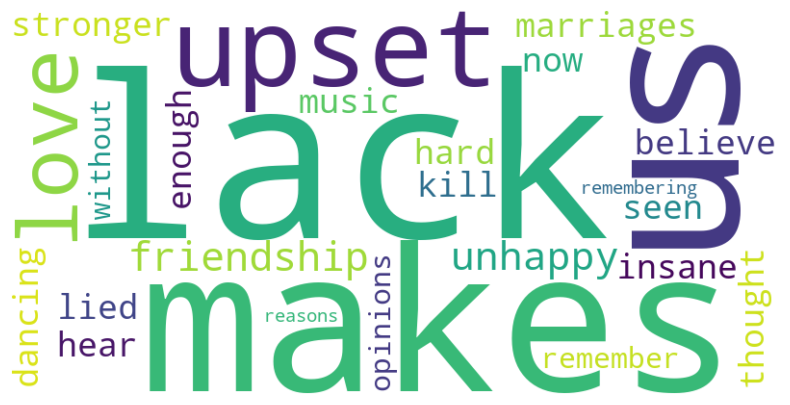

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# List of quotes
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

# Combine all quotes into a single string
text = " ".join(quotes)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
